# Working with non grid data

In [1]:
import hvplot.xarray  # noqa: adds hvplot methods to xarray objects
import hvplot
import matplotlib.pyplot as plt

hvplot.extension()

In [4]:
import numpy as np
import pandas as pd
from spatialize.gs.esi import esi_hparams_search, esi_nongriddata
import spatialize.gs.esi.aggfunction as af
import spatialize.gs.esi.lossfunction as lf
import xarray as xr

# the samples

# NOTE: modify this to make it download the CSV from
# the GitHub repo
samples = pd.read_csv('../../test/testdata/data.csv')
with open('../../test/testdata/grid.dat', 'r') as data:
    lines = data.readlines()
    lines = [l.strip().split() for l in lines[5:]]
    aux = np.float32(lines)
locations = pd.DataFrame(aux, columns=['X', 'Y', 'Z'])

w, h = 300, 200

In [5]:
points = samples[['x', 'y']].values
values = samples[['cu']].values[:, 0]
xi = locations[['X', 'Y']].values

# operational error function for the observed dynamic range
#op_error_precision=pf.OpErrorPrecision(np.abs(np.min(values) - np.max(values)))

# operational error function for the observed mean law
# op_error_precision=pf.OpErrorPrecision(np.nanmean(values))

In [6]:
points

array([[341, 477],
       [141, 415],
       [235, 207],
       [ 13, 569],
       [ 19, 313],
       [ 49, 573],
       [ 31,  45],
       [ 41, 125],
       [191, 465],
       [ 87, 549],
       [291, 469],
       [257, 177],
       [217,  91],
       [127, 509],
       [161, 471],
       [ 91, 163],
       [129, 137],
       [111, 193],
       [317, 497],
       [231, 493],
       [ 59, 343],
       [195, 343],
       [309, 171],
       [263, 419],
       [313, 477],
       [169, 265],
       [323, 267],
       [255, 279],
       [269, 167],
       [205, 405],
       [385, 541],
       [167, 545],
       [ 15, 449],
       [ 45, 157],
       [309, 413],
       [211,  79],
       [ 11,  75],
       [ 95, 115],
       [277,  87],
       [159, 351],
       [397,  43],
       [211, 493],
       [287, 433],
       [223, 555],
       [273, 295],
       [127, 393],
       [333, 533],
       [173, 323],
       [237, 169],
       [219, 585],
       [367,  21],
       [317, 195],
       [261,

In [7]:
values

array([0.419, 1.547, 1.138, 0.641, 0.421, 0.825, 0.752, 0.494, 1.467,
       0.559, 0.55 , 0.809, 1.535, 1.281, 2.42 , 1.215, 2.266, 1.591,
       0.393, 0.637, 1.716, 0.999, 0.859, 1.483, 0.491, 1.377, 0.87 ,
       0.891, 0.946, 1.462, 0.409, 0.858, 0.563, 0.362, 0.589, 1.475,
       0.402, 1.545, 1.105, 1.207, 0.475, 0.826, 0.96 , 0.482, 0.947,
       1.421, 0.436, 1.307, 0.75 , 0.593, 0.342, 0.812, 0.599, 1.183,
       0.836, 1.732, 0.652, 1.56 , 1.246, 0.414, 1.134, 1.255, 0.806,
       0.955, 0.455, 1.512, 2.359, 0.383, 1.097, 0.338, 0.884, 1.899,
       0.423, 1.031, 0.622, 0.647, 1.137, 1.271, 1.036, 0.821, 0.677,
       0.707, 0.828, 1.079, 1.614, 1.245, 1.79 , 0.766, 2.374, 0.696,
       1.052, 0.491, 0.633, 1.03 , 0.879, 1.032, 1.342, 1.95 , 0.402,
       0.421, 0.626, 0.449, 0.852, 0.942, 0.792, 0.399, 1.329, 0.411,
       0.362, 0.826, 0.548, 1.11 , 0.997, 0.405, 1.298, 1.138, 0.385,
       0.788, 0.823, 0.443, 3.609, 0.772, 0.854, 1.062, 1.397, 0.522,
       1.547, 0.676,

In [10]:
xi

array([[  1.,   1.],
       [  3.,   1.],
       [  5.,   1.],
       ...,
       [395., 599.],
       [397., 599.],
       [399., 599.]], dtype=float32)

In [18]:
samples_2=samples['x', 'y', 'cu']

KeyError: ('x', 'y', 'cu')

In [16]:
samples_2

array([[3.410e+02, 4.770e+02, 4.190e-01],
       [1.410e+02, 4.150e+02, 1.547e+00],
       [2.350e+02, 2.070e+02, 1.138e+00],
       ...,
       [1.590e+02, 1.690e+02, 1.370e+00],
       [2.950e+02, 3.890e+02, 6.440e-01],
       [3.670e+02, 2.910e+02, 6.800e-01]])

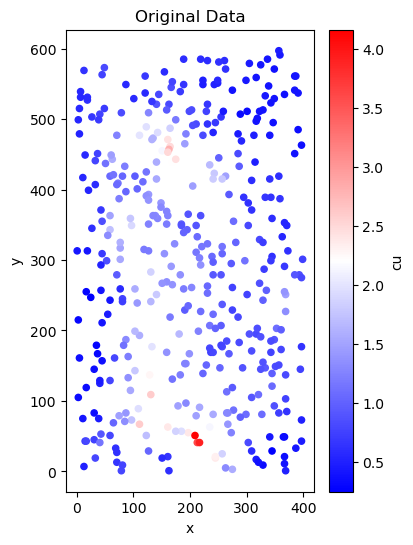

In [26]:
import matplotlib.pyplot as plt

ax2 = samples.plot.scatter(x='x',
                      y='y',
                      c='cu',
                      colormap='bwr', figsize=(4,6), title='Original Data')
plt.savefig('original_nongrid.png')


In [12]:
locations

,X,Y,Z
0,1.0,1.0,97.5
1,3.0,1.0,97.5
2,5.0,1.0,97.5
3,7.0,1.0,97.5
4,9.0,1.0,97.5
...,...,...,...
59995,391.0,599.0,97.5
59996,393.0,599.0,97.5
59997,395.0,599.0,97.5
59998,397.0,599.0,97.5


In [4]:
b_params = esi_hparams_search(points, values, xi,
                              base_interpolator="idw", griddata=False, k=10,
                              exponent=list(np.arange(1.0, 15.0, 1.0)),
                              alpha=(0.5, 0.6, 0.8, 0.9, 0.95))
b_params

In [7]:
grid_z4, grid_z4p = esi_nongriddata(points, values, xi,
                                    base_interpolator="idw",
                                    exponent=5.0,
                                    n_partitions=100, alpha=0.8,
                                    agg_function=af.mean, prec_function=op_error_precision)
ds4 = xr.DataArray(grid_z4.reshape(w, h))
ds4p = xr.DataArray(grid_z4p.reshape(w, h) * 100)

fig = ds4.hvplot.image(title="esi idw", width=w, height=h * 2, xlabel='X', ylabel='Y', cmap='bwr', clim=(0, 4.5))
fig += ds4p.hvplot.image(title="esi idw UQ", width=w, height=h * 2, xlabel='X', ylabel='Y', cmap='Spectral')
fig

In [6]:
b_params = esi_hparams_search(points, values, xi,
                              base_interpolator="kriging", griddata=False, k=10,
                              model=["spherical", "exponential", "cubic", "gaussian"],
                              nugget=[0.0, 0.5, 1.0],
                              range=[100.0, 500.0, 1000.0, 5000.0],
                              alpha=list(np.flip(np.arange(0.90, 0.95, 0.01))))
b_params

In [8]:
grid_z4, grid_z4p = esi_nongriddata(points, values, xi,
                                    base_interpolator="kriging",
                                    model="cubic", nugget=0.0, range=1000.0,
                                    n_partitions=100, alpha=0.93,
                                    agg_function=af.median, prec_function=op_error_precision)
ds4 = xr.DataArray(grid_z4.reshape(w, h))
ds4p = xr.DataArray(grid_z4p.reshape(w, h) * 100)

fig = ds4.hvplot.image(title="esi kriging", width=w, height=h * 2, xlabel='X', ylabel='Y', cmap='bwr', clim=(0, 4.5))
fig += ds4p.hvplot.image(title="esi kriging UQ", width=w, height=h * 2, xlabel='X', ylabel='Y', cmap='Spectral')
fig